In [189]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
import scqubits as scq
from scqubits import ParameterSweep

In [190]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [191]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 4
rr_freq_target = np.array([7.27e9, 7.2e9, 7.4e9, 7.6e9])
qubit_freq_target = np.array([5.281e9, 4.7e9, 4.9e9, 5.1e9])
c_sigma = 90.5e-15
kappa_target = 46.7e6
target_parameters = {
    "chi": 0.325e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [192]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1]/2 - target_parameters["chi"])
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [193]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [4, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[3.01361450e-15 3.97254100e-15 3.80903672e-15 3.65659073e-15]
[9.23537297e-09 1.15377289e-08 1.06564788e-08 9.87234458e-09]


In [194]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [195]:
anharmonicities = np.zeros(4)
for i in range(4):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  5.4131549835205075e-08 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

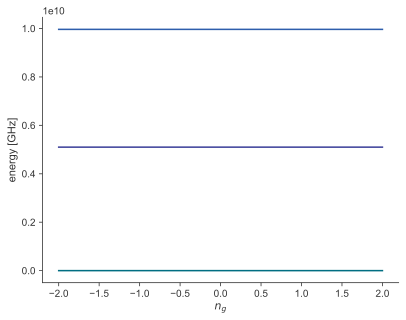

In [196]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [197]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |      5.5 GHz |       383 Hz |      213 MHz |
            1 |     7.27 GHz |      581 kHz |       495 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      213 MHz |              |
            1 |      650 kHz |       495 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.92 GHz |       280 Hz |      213 MHz |
            1 |      7.2 GHz |      576 kHz |       495 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      213 MHz |              |
            1 |      650 kHz |       495 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.12 GHz |       299 Hz |      213 MHz |
            1 |      7.4 GHz |      592 kHz |       495 Hz |

Kerr coefficients (diagonal = Kerr, off-diag

 C:\Users\moret\AppData\Local\Temp\ipykernel_8360\664116265.py: 19

In [198]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [199]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([60557852.790946  , 74779537.06582528, 75171880.95722099,
       75543454.364892  ])

In [200]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi * np.sqrt(2)
    return abs(k - kappa_target)

In [201]:
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
cks

array([-5.13756666e-14, -5.21267132e-14, -5.00278117e-14, -4.80660792e-14])

In [202]:
resonator_kappa(rr_freq_target[0], cks[0], Z0) / 2 / np.pi

33021886.681411773

In [203]:
expected_Q = np.pi/(cks**2 * (2*np.pi*rr_freq_target)**2 * Z0**2)
expected_Q

array([220.15701496, 218.03720876, 224.09379789, 230.15038702])

In [204]:
# # I think this is the right one. Check with eigenmode!
# digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
# tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
# c_l, l_l = cpw_cl_ll(a, b, ep_r)
# v_ph = 1/np.sqrt(c_l*l_l)
# unloaded_wg_lengths = v_ph / rr_freq_target / 2
# l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
#                                 (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
# c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
#                                 (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
# c_r_loaded -= cqrs
# c_r_loaded -= cks
# resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
# resonator_waveguide_lengths

In [205]:
# coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
# ck_given_coupling = get_ck()
# for i in range(nb_qubits):
#     coupler_width = coupler_width_given_c_qr(cqrs[i])
#     finger_control = ck_given_coupling(cks[i])
#     print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
#     print(f"Finger control for qubit {i}: {finger_control:.5}")
#     print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

In [206]:
fl_traits = pd.read_csv("single_doublepads_05.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_05.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_05.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[3] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[4] + (a+2*b)/2*1e6]

In [207]:
resonator_capacitance = c_r - cks -  cqrs

options = {
    "qubit_c": np.array([c_sigma]*4),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": np.array(cks),
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.603, 7.609],
    "n_points": 1001,
    "type": "simple",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

2-Port Network: '',  7.603-7.609 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


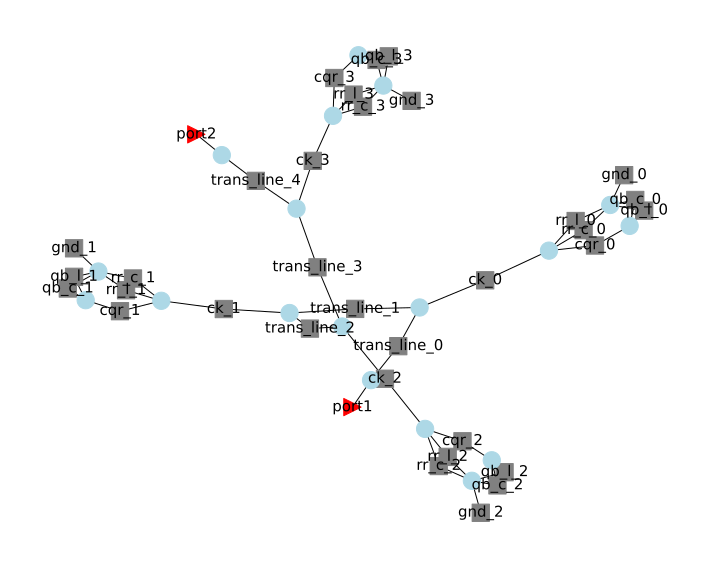

In [208]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

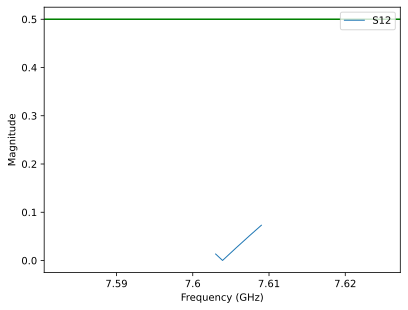

In [209]:
ntw.plot_s_mag(m=0, n=1, lw=1)
import matplotlib.pyplot as plt
shift = -0.0007e9

plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1] + shift,
           xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1] + shift, colors="green")

In [210]:
kappa_target

46700000.0

In [211]:
resonator_kappa(7e9, cks[0], Z0)/2/np.pi

29477644.040854044

In [212]:
Z0

50.90224340324664

In [213]:
# from modeling.resonance_fit import ResFit
# # https://eprints.gla.ac.uk/323700/1/323700.pdf
# initial_params = [1, 1e4, 1, 1, 0, 0, 0]
# fitter = ResFit(ntw, 300, -1, ideal = True)
# fitter.fit_resonance(initial_params=initial_params)
# fitter.plot_resonance()

In [214]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print(T1_purcell)

[3.67647724e-06 3.80905921e-06 3.76940180e-06 3.73241210e-06]


In [215]:
g_r_f = rr_freq_target**2*4*np.pi**2*Z0/2 * cks**2
c_r*2*np.pi*rr_freq_target/g_r_f

array([89.22627737, 88.36715228, 90.8217954 , 93.27643852])

In [216]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [217]:
df = pd.DataFrame(columns=['resonator 01','qubit 01', 'anharmonicity','chi/2pi','g/2pi', 'C_sigma', 'Lj', 'Ic', 'T1 Purcell'], index=['qb0','qb1','qb2', 'qb3'])
df['resonator 01'] = rr_freq_target
df['qubit 01'] = qubit_freq_target
df['anharmonicity'] = anharmonicities
df['chi/2pi'] = [target_parameters["chi"]]*4
df['g/2pi'] = g/2/np.pi
df['C_sigma'] = [c_sigma]*4
df["Lj"] = Ljs
df['Ic'] = Ic
df['T1 Purcell'] = T1_purcell

In [218]:
df

,resonator 01,qubit 01,anharmonicity,chi/2pi,g/2pi,C_sigma,Lj,Ic,T1 Purcell
qb0,7.270000e+09,5.281000e+09,-2.370028e+08,325000.0,6.055785e+07,9.050000e-14,9.235373e-09,3.563537e-08,0.000004
qb1,7.200000e+09,4.700000e+09,-2.404788e+08,325000.0,7.477954e+07,9.050000e-14,1.153773e-08,2.852433e-08,0.000004
qb2,7.400000e+09,4.900000e+09,-2.391653e+08,325000.0,7.517188e+07,9.050000e-14,1.065648e-08,3.088318e-08,0.000004
qb3,7.600000e+09,5.100000e+09,-2.379802e+08,325000.0,7.554345e+07,9.050000e-14,9.872345e-09,3.333615e-08,0.000004


In [219]:
from modeling.chips.detection_device_2s1a.utils import get_transmission_line_tee_points, NetworkAnalysis

In [220]:
options = {
    "qubit_c": np.array([c_sigma]*4),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": np.array(cks),
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.603, 7.609],
    "n_points": 1001,
    "type": "simple",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

In [225]:

options = {
    "qubit_c": [np.array([c_sigma])],
    "qubit_l": Ljs[1],
    "readout_resonator_c": [resonator_capacitance[0]],
    "readout_resonator_l": [l_r[0]],
    "ck": [-np.array(cks)[0]],
    "ck_to_ground": [0],
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [6.03, 7.609],
    "n_points": 1001,
    "type": "simple",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}
network = NetworkAnalysis(options=options)
t1_readout = network.t1_purcell_readout(qb_frequency = 5.242, c_sigma = 90e-15, with_purcell_filter = False)
t1_readout * 1e6

2.868032671908484

In [226]:
cks

array([-5.13756666e-14, -5.21267132e-14, -5.00278117e-14, -4.80660792e-14])

In [223]:
cks

array([-5.13756666e-14, -5.21267132e-14, -5.00278117e-14, -4.80660792e-14])